In [1]:
# ### 1. Imports and Setup

import keras_tuner as kt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, regularizers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Set random seeds for reproducibility
tf.random.set_seed(0)
np.random.seed(0)



In [3]:
# Load and prepare data


def load_data(train_path, test_path):
    # Training data
    df = pd.read_csv(train_path,
                     names=[0, 1, 2, 3, 4, 5, 6, "index"],
                     delimiter=" ")
    df.set_index("index", inplace=True)
    y_train = df.iloc[:, 0].values
    X_train = df.iloc[:, 1:].values

    # Test data
    test_df = pd.read_csv(test_path,
                          names=[0, 1, 2, 3, 4, 5, 6, "index"],
                          delimiter=" ")
    test_df.set_index("index", inplace=True)
    y_test = test_df.iloc[:, 0].values
    X_test = test_df.iloc[:, 1:].values

    return (X_train, y_train), (X_test, y_test)


# Load data
(X_train, y_train), (X_test, y_test) = load_data(
    "../ML_project/data/Monk_2/monks-2.train",
    "../ML_project/data/Monk_2/monks-2.test"
)

# Split validation set
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

# Normalization
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Convert targets to categorical
y_train = tf.keras.utils.to_categorical(y_train, 2)
y_val = tf.keras.utils.to_categorical(y_val, 2)
y_test = tf.keras.utils.to_categorical(y_test, 2)

In [4]:
# ### 3. Model Building
# ### 3.1. We can change the activation functions and weight initializers based on our preferences

def build_model(hidden_size=10,
                activation='relu',
                l1=0.0,
                l2=0.0,
                dropout_rate=0.0,
                learning_rate=0.001):

    model = tf.keras.Sequential([
        layers.Dense(hidden_size,
                     activation=activation,
                     kernel_regularizer=regularizers.L1L2(l1, l2),
                     kernel_initializer='he_normal'),
        layers.Dropout(dropout_rate),
        layers.Dense(2, activation='softmax')
    ])

    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

In [5]:
# ### 4. Hyperparameter Tuning

def tuner_builder(hp):
    return build_model(
        hidden_size=hp.Int('hidden_size', 8, 16, step=4),
        activation=hp.Choice('activation', ['relu', 'sigmoid', 'leaky_relu']),
        l1=hp.Float('l1', 0.0, 1e-4, step=1e-5),
        l2=hp.Float('l2', 0.0, 1e-4, step=1e-5),
        dropout_rate=hp.Float('dropout', 0.0, 0.5, step=0.1),
        learning_rate=hp.Choice('learning_rate', [1e-3, 5e-4])
    )


tuner = kt.RandomSearch(
    tuner_builder,
    objective='val_accuracy',
    max_trials=20,
    executions_per_trial=2,
    directory='tuner_results',
    project_name='monk2_classification'
)

tuner.search(X_train, y_train,
             epochs=200,
             batch_size=4,
             validation_data=(X_val, y_val),
             verbose=1)

# Get best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

Trial 20 Complete [00h 01m 27s]
val_accuracy: 0.5147058814764023

Best val_accuracy So Far: 0.7352941036224365
Total elapsed time: 00h 29m 16s


In [7]:
# Build best model

model = build_model(
    hidden_size=best_hps.get('hidden_size'),
    activation=best_hps.get('activation'),
    l1=best_hps.get('l1'),
    l2=best_hps.get('l2'),
    dropout_rate=best_hps.get('dropout'),
    learning_rate=best_hps.get('learning_rate')
)

# Training with early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    patience=20,
    restore_best_weights=True,
    monitor='val_accuracy'
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=350,
    batch_size=4,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/350
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.4764 - loss: 1.1257 - val_accuracy: 0.4706 - val_loss: 1.0828
Epoch 2/350
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4714 - loss: 1.0455 - val_accuracy: 0.4412 - val_loss: 1.0419
Epoch 3/350
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4834 - loss: 0.9874 - val_accuracy: 0.3235 - val_loss: 1.0096
Epoch 4/350
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5272 - loss: 0.9402 - val_accuracy: 0.3529 - val_loss: 0.9830
Epoch 5/350
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5545 - loss: 0.9004 - val_accuracy: 0.3824 - val_loss: 0.9596
Epoch 6/350
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5715 - loss: 0.8653 - val_accuracy: 0.4412 - val_loss: 0.9385
Epoch 7/350
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5419 - loss: 0.8339 - val_accuracy: 0.4118 - val_loss: 0.9194
Epoch 8/350
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5486 - loss: 0.8059 - val_accuracy: 0.4412 - v

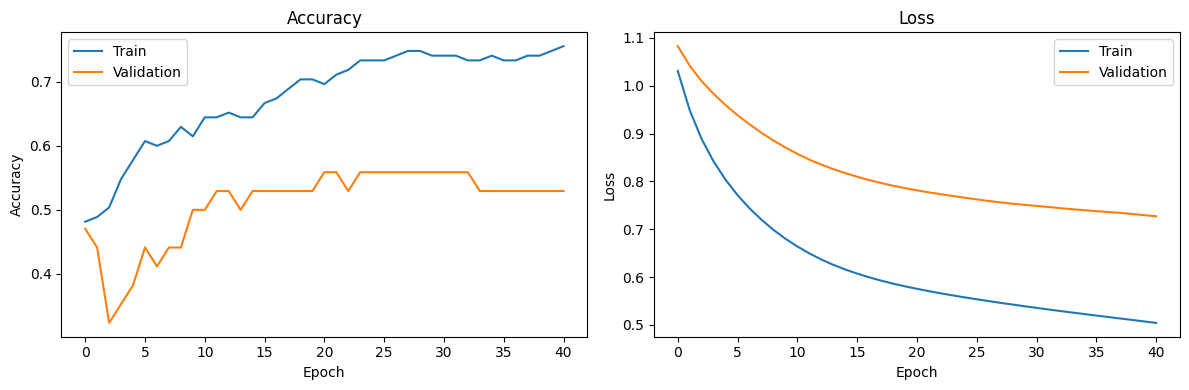


Test Accuracy: 0.6852


In [8]:
# Plot training history


def plot_history(history):
    plt.figure(figsize=(12, 4))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Validation')
    plt.title('Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.title('Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()

    plt.tight_layout()
    plt.show()


plot_history(history)

# Final evaluation
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"\nTest Accuracy: {test_acc:.4f}")

In [9]:
# ### 7. Model Summary

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 16)             │           112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │            34 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 440 (1.72 KB)

 Trainable params: 146 (584.00 B)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 294 (1.15 KB)